So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 50
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 1

Example of what worked before

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = D)
    if vae_gumbel_truncated.t >= 0.01:
        vae_gumbel_truncated.t *= 0.75
    if epoch > 5 and epoch <25:
        gradients_before_burnin += grads
    if epoch == 25:
        with torch.no_grad():
            # collect a version of the select keys at this point
            w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
            subset_indices_before_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()
    if epoch > 24:
        gradient_post_burn_in += grads
        
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices_post_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()

Train Epoch: 1 [0/8000 (0%)]	Loss: 21.246294
Train Epoch: 1 [1280/8000 (16%)]	Loss: 20.250397
Train Epoch: 1 [2560/8000 (32%)]	Loss: 19.305346
Train Epoch: 1 [3840/8000 (48%)]	Loss: 18.313152
Train Epoch: 1 [5120/8000 (64%)]	Loss: 17.451023
Train Epoch: 1 [6400/8000 (80%)]	Loss: 16.190554
Train Epoch: 1 [7680/8000 (96%)]	Loss: 14.823248
====> Epoch: 1 Average loss: 18.0863
Train Epoch: 2 [0/8000 (0%)]	Loss: 13.966923
Train Epoch: 2 [1280/8000 (16%)]	Loss: 13.805084
Train Epoch: 2 [2560/8000 (32%)]	Loss: 13.408572
Train Epoch: 2 [3840/8000 (48%)]	Loss: 13.038525
Train Epoch: 2 [5120/8000 (64%)]	Loss: 12.352503
Train Epoch: 2 [6400/8000 (80%)]	Loss: 12.367773
Train Epoch: 2 [7680/8000 (96%)]	Loss: 11.958294
====> Epoch: 2 Average loss: 13.1279
Train Epoch: 3 [0/8000 (0%)]	Loss: 12.673205
Train Epoch: 3 [1280/8000 (16%)]	Loss: 12.181462
Train Epoch: 3 [2560/8000 (32%)]	Loss: 12.358383
Train Epoch: 3 [3840/8000 (48%)]	Loss: 12.377422
Train Epoch: 3 [5120/8000 (64%)]	Loss: 12.426563
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 10.782840
Train Epoch: 22 [7680/8000 (96%)]	Loss: 10.292208
====> Epoch: 22 Average loss: 10.6665
Train Epoch: 23 [0/8000 (0%)]	Loss: 10.157126
Train Epoch: 23 [1280/8000 (16%)]	Loss: 10.540656
Train Epoch: 23 [2560/8000 (32%)]	Loss: 10.753371
Train Epoch: 23 [3840/8000 (48%)]	Loss: 10.622337
Train Epoch: 23 [5120/8000 (64%)]	Loss: 10.741127
Train Epoch: 23 [6400/8000 (80%)]	Loss: 10.701597
Train Epoch: 23 [7680/8000 (96%)]	Loss: 10.534987
====> Epoch: 23 Average loss: 10.6281
Train Epoch: 24 [0/8000 (0%)]	Loss: 10.502141
Train Epoch: 24 [1280/8000 (16%)]	Loss: 10.684061
Train Epoch: 24 [2560/8000 (32%)]	Loss: 10.734015
Train Epoch: 24 [3840/8000 (48%)]	Loss: 10.379245
Train Epoch: 24 [5120/8000 (64%)]	Loss: 10.957211
Train Epoch: 24 [6400/8000 (80%)]	Loss: 10.496857
Train Epoch: 24 [7680/8000 (96%)]	Loss: 10.607121
====> Epoch: 24 Average loss: 10.6134
Train Epoch: 25 [0/8000 (0%)]	Loss: 10.293395
Train Epoch: 25 [1280/8000 (16%)]	Loss: 10.52864

Train Epoch: 44 [1280/8000 (16%)]	Loss: 10.093376
Train Epoch: 44 [2560/8000 (32%)]	Loss: 10.071982
Train Epoch: 44 [3840/8000 (48%)]	Loss: 10.949146
Train Epoch: 44 [5120/8000 (64%)]	Loss: 10.586852
Train Epoch: 44 [6400/8000 (80%)]	Loss: 10.686936
Train Epoch: 44 [7680/8000 (96%)]	Loss: 10.196752
====> Epoch: 44 Average loss: 10.4038
Train Epoch: 45 [0/8000 (0%)]	Loss: 10.245931
Train Epoch: 45 [1280/8000 (16%)]	Loss: 10.678970
Train Epoch: 45 [2560/8000 (32%)]	Loss: 10.351840
Train Epoch: 45 [3840/8000 (48%)]	Loss: 10.163573
Train Epoch: 45 [5120/8000 (64%)]	Loss: 10.464585
Train Epoch: 45 [6400/8000 (80%)]	Loss: 10.633328
Train Epoch: 45 [7680/8000 (96%)]	Loss: 10.427898
====> Epoch: 45 Average loss: 10.3855
Train Epoch: 46 [0/8000 (0%)]	Loss: 10.302140
Train Epoch: 46 [1280/8000 (16%)]	Loss: 10.518029
Train Epoch: 46 [2560/8000 (32%)]	Loss: 10.528069
Train Epoch: 46 [3840/8000 (48%)]	Loss: 9.742825
Train Epoch: 46 [5120/8000 (64%)]	Loss: 10.304817
Train Epoch: 46 [6400/8000 (80%)]

tensor(1.4094e+12, device='cuda:0')
tensor(8.1824e+11, device='cuda:0')


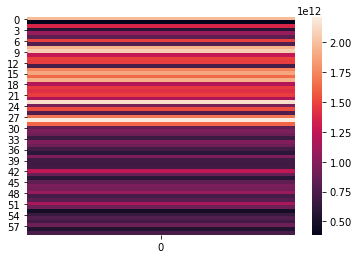

In [14]:
print(gradients_before_burnin[:D].mean())
print(gradients_before_burnin[D:].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(5.2290e+12, device='cuda:0')
tensor(2.3107e+12, device='cuda:0')


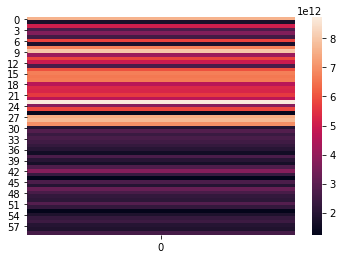

In [15]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.4557)
tensor(3.5443)


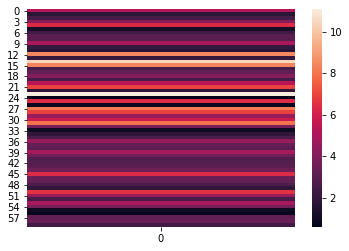

In [16]:
print(subset_indices_before_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_before_burnin.sum(dim = 0)[D:].mean())
sns.heatmap(subset_indices_before_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.3393)
tensor(3.6607)


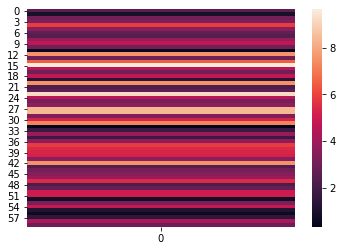

In [17]:
print(subset_indices_post_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_post_burnin.sum(dim = 0)[(D):].mean())
sns.heatmap(subset_indices_post_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)].sum() - subset_indices_post_burnin.sum(dim = 0)[(D//2):].sum()

tensor(-132.5392)

The new model


In [34]:
logits_changed_loss_lambda = 0.000001
alpha = 0.90

In [35]:
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t, alpha = alpha)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [36]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D,
                                                      logits_changed_loss_lambda=logits_changed_loss_lambda,
                                                      DEBUG = True)
    
    if vae_gumbel_truncated.t >= 0.01:
        vae_gumbel_truncated.t *= 0.75
    if epoch > 5 and epoch <25:
        gradients_before_burnin += grads
    if epoch == 25:
        with torch.no_grad():
            # collect a version of the select keys at this point
            print("GUMBEL DEBUG")
            w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
            subset_indices_before_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()
        
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > 24:
        gradient_post_burn_in += grads
        
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices_post_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.636711
Train Epoch: 1 [1280/8000 (16%)]	Loss: 40.626431
Train Epoch: 1 [2560/8000 (32%)]	Loss: 39.592697
Train Epoch: 1 [3840/8000 (48%)]	Loss: 38.860477
Train Epoch: 1 [5120/8000 (64%)]	Loss: 37.844345
Train Epoch: 1 [6400/8000 (80%)]	Loss: 36.929195
Loss tensor(2348.0864, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(4815.0645, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(2329.1528, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(4983.5293, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 1 [7680/8000 (96%)]	Loss: 35.834110
====> Epoch: 1 Average loss: 38.6637
Train Epoch: 2 [0/8000 (0%)]	Loss: 35.526077
Train Epoch: 2 [1280/8000 (16%)]	Loss: 34.590858
Train Epoch: 2 [2560/8000 (32%)]	Loss: 33.968864
Train Epoch: 2 [3840/8000 (48%)]	Loss: 33.364674
Train Epoch: 2 [5120/8000 (64%)]	Loss: 33.706108
Train Epoch: 2 [6400/8000 (80%)]	Loss: 33.224529
Train Epoch: 2 [7680/8000 (96%)]	Loss: 33.769554
====> Epoch

Train Epoch: 15 [7680/8000 (96%)]	Loss: 32.019131
====> Epoch: 15 Average loss: 32.1882
Train Epoch: 16 [0/8000 (0%)]	Loss: 32.896400
Train Epoch: 16 [1280/8000 (16%)]	Loss: 32.254379
Train Epoch: 16 [2560/8000 (32%)]	Loss: 31.942026
Train Epoch: 16 [3840/8000 (48%)]	Loss: 32.238140
Train Epoch: 16 [5120/8000 (64%)]	Loss: 31.625650
Train Epoch: 16 [6400/8000 (80%)]	Loss: 32.093521
Loss tensor(2070.2905, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(78247.6250, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 16 [7680/8000 (96%)]	Loss: 32.186977
====> Epoch: 16 Average loss: 32.1153
Train Epoch: 17 [0/8000 (0%)]	Loss: 31.937471
Train Epoch: 17 [1280/8000 (16%)]	Loss: 32.183693
Loss tensor(2055.1973, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(78694.0156, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 17 [2560/8000 (32%)]	Loss: 31.947483
Train Epoch: 17 [3840/8000 (48%)]	Loss: 31.570192
Train Epoch: 17 [5120/8000 (64%)]	Loss: 31.991409
Train 

Train Epoch: 30 [5120/8000 (64%)]	Loss: 31.283985
Train Epoch: 30 [6400/8000 (80%)]	Loss: 31.867334
Loss tensor(2017.6396, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 30 [7680/8000 (96%)]	Loss: 32.003944
====> Epoch: 30 Average loss: 31.7267
Train Epoch: 31 [0/8000 (0%)]	Loss: 31.712223
Train Epoch: 31 [1280/8000 (16%)]	Loss: 32.233299
Train Epoch: 31 [2560/8000 (32%)]	Loss: 31.543877
Train Epoch: 31 [3840/8000 (48%)]	Loss: 32.170395
Train Epoch: 31 [5120/8000 (64%)]	Loss: 31.638626
Train Epoch: 31 [6400/8000 (80%)]	Loss: 31.786312
Train Epoch: 31 [7680/8000 (96%)]	Loss: 31.387098
====> Epoch: 31 Average loss: 31.6753
Train Epoch: 32 [0/8000 (0%)]	Loss: 31.530561
Train Epoch: 32 [1280/8000 (16%)]	Loss: 31.554827
Train Epoch: 32 [2560/8000 (32%)]	Loss: 31.597212
Train Epoch: 32 [3840/8000 (48%)]	Loss: 31.658976
Train Epoch: 32 [5120/8000 (64%)]	Loss: 31.851763
Train Epoch: 32 [6400/8000 (80%)]	Loss: 31.930906
Train Epoch: 32 [7680/8000 (96%)]	Loss: 31.751801
====>

Train Epoch: 49 [1280/8000 (16%)]	Loss: 31.227770
Loss tensor(2022.8519, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 49 [2560/8000 (32%)]	Loss: 31.775154
Loss tensor(2023.0359, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 49 [3840/8000 (48%)]	Loss: 30.957611
Train Epoch: 49 [5120/8000 (64%)]	Loss: 31.294201
Train Epoch: 49 [6400/8000 (80%)]	Loss: 31.297764
Train Epoch: 49 [7680/8000 (96%)]	Loss: 31.139065
====> Epoch: 49 Average loss: 31.5288
Train Epoch: 50 [0/8000 (0%)]	Loss: 31.401352
Train Epoch: 50 [1280/8000 (16%)]	Loss: 31.260931
Train Epoch: 50 [2560/8000 (32%)]	Loss: 31.553074
Train Epoch: 50 [3840/8000 (48%)]	Loss: 31.372044
Train Epoch: 50 [5120/8000 (64%)]	Loss: 31.241632
Train Epoch: 50 [6400/8000 (80%)]	Loss: 32.108192
Train Epoch: 50 [7680/8000 (96%)]	Loss: 31.437546
====> Epoch: 50 Average loss: 31.5506


tensor(17196.4551, device='cuda:0')
tensor(3842.1572, device='cuda:0')


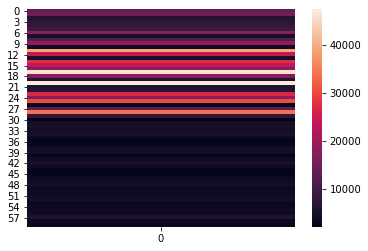

In [37]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(60232.6914, device='cuda:0')
tensor(8670.8799, device='cuda:0')


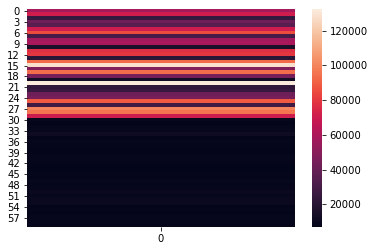

In [38]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.4151)
tensor(3.5849)


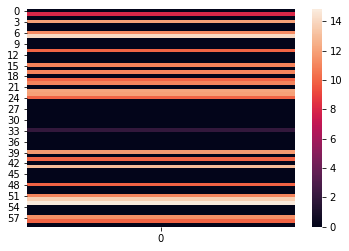

In [39]:
print(subset_indices_before_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_before_burnin.sum(dim = 0)[D:].mean())
sns.heatmap(subset_indices_before_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.3096)
tensor(3.6904)


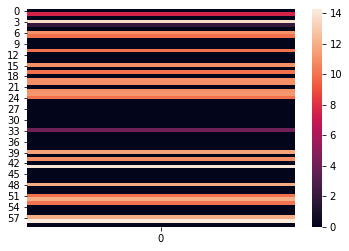

In [40]:
print(subset_indices_post_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_post_burnin.sum(dim = 0)[D:].mean())
sns.heatmap(subset_indices_post_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [41]:
(subset_indices_post_burnin.sum(dim = 0)[:(D//2)] > 0).sum()

tensor(6)

In [42]:
(subset_indices_post_burnin.sum(dim = 0)[(D//2):] > 0).sum()

tensor(17)

In [43]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)]

tensor([ 0.0000,  7.5124,  0.0000, 13.7548,  2.0000,  0.0000, 11.0219, 10.0003,
         0.0000,  0.0000,  0.0000, 10.0000,  0.0000,  0.0000,  0.0000])

In [44]:
subset_indices_post_burnin.sum(dim = 0)[(D//2):]

tensor([10.9268,  0.0000, 10.0000,  0.0000, 10.9597, 10.9288,  0.0000, 10.9957,
        11.1886, 10.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  4.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        11.5824,  0.0000, 10.8844,  0.0000, 14.0204,  0.0000,  0.0000,  0.0000,
         0.0000, 11.9410,  0.0000,  0.0000, 10.0001, 11.9627, 10.0843,  0.0000,
         0.0000,  0.0000, 11.9997, 14.2360,  0.0000])

In [45]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)].sum() - subset_indices_post_burnin.sum(dim = 0)[(D//2):].sum()

tensor(-131.4212)

In [52]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, k = 3*z_size, t= 0.0001), 
                        descending = True)[0, :3*z_size]

In [53]:
sum(top_ind < 30)

tensor(13, device='cuda:0')

In [54]:
sum(top_ind >= 30)

tensor(11, device='cuda:0')

In [55]:
top_ind

tensor([31, 29, 26, 27, 19, 20, 37, 39, 16, 12, 13,  9,  8, 15, 21, 22, 44, 40,
        41, 42, 33, 36, 50, 58], device='cuda:0')